## Import Dataset From Kaggle

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
#!/bin/bash
!kaggle datasets download alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
 89% 201M/225M [00:01<00:00, 99.9MB/s]
100% 225M/225M [00:01<00:00, 122MB/s] 


### Extract the datasets from Zip file

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/flowers-recognition.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Import required modules

In [30]:

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [31]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    '/content/flowers',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


validation_generator = train_datagen.flow_from_directory(
    '/content/flowers',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [32]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [33]:
validation_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

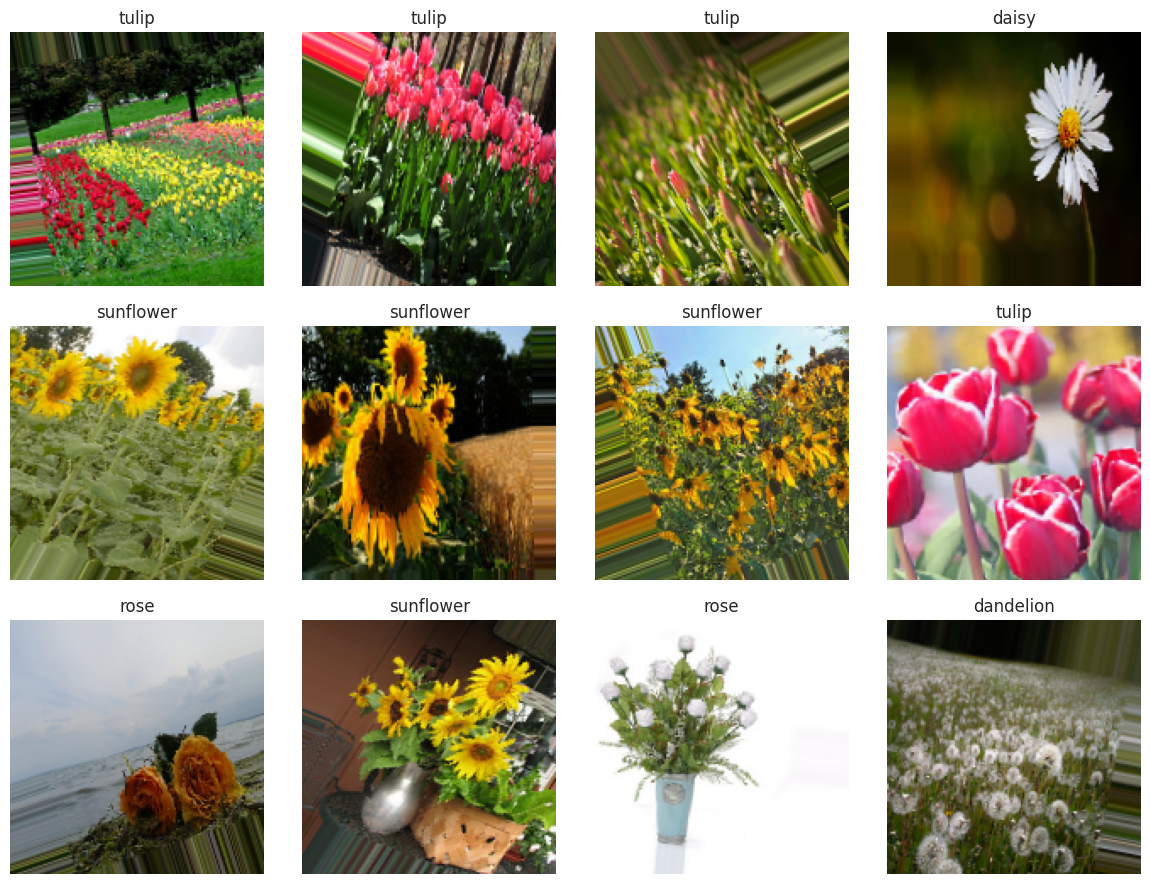

In [45]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Define a dictionary to map class indices to class names
res_dict = {v: k for k, v in train_generator.class_indices.items()}

# Visualize the first few samples
plt.figure(figsize=(12, 9))
for i in range(min(12, len(images))):  # Display up to 12 samples
    ax = plt.subplot(3, 4, i + 1)  # Create a grid of 3x4
    plt.imshow(images[i])  # Display the image
    plt.title(res_dict[np.argmax(labels[i])])  # Display the class label
    plt.axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()

In [34]:
## Build our CNN Model
def build_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    return model

In [35]:
model = build_model()

In [36]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      10,617,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 11,012,293 (42.01 MB)

 Trainable params: 11,010,309 (42.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.5, min_lr=1e-6)

In [40]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[lr_reduction]
)

Epoch 1/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 30s 266ms/step - accuracy: 0.5910 - loss: 1.0529 - val_accuracy: 0.5140 - val_loss: 1.3434 - learning_rate: 0.0010
Epoch 2/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.6101 - loss: 1.0392 - val_accuracy: 0.5791 - val_loss: 1.1499 - learning_rate: 0.0010
Epoch 3/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 42s 273ms/step - accuracy: 0.6373 - loss: 0.9662 - val_accuracy: 0.6279 - val_loss: 1.0869 - learning_rate: 0.0010
Epoch 4/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.6510 - loss: 0.9090 - val_accuracy: 0.6419 - val_loss: 0.9800 - learning_rate: 0.0010
Epoch 5/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 30s 262ms/step - accuracy: 0.6550 - loss: 0.8894 - val_accuracy: 0.6512 - val_loss: 0.9595 - learning_rate: 0.0010
Epoch 6/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 30s 263ms/step - accuracy: 0.6836 - loss: 0.8327 - val_accuracy: 0.6558 - val_loss: 0.9710 - learning_rate: 0.0010
Epoch 7/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 31s 272ms/step - accuracy: 0.6

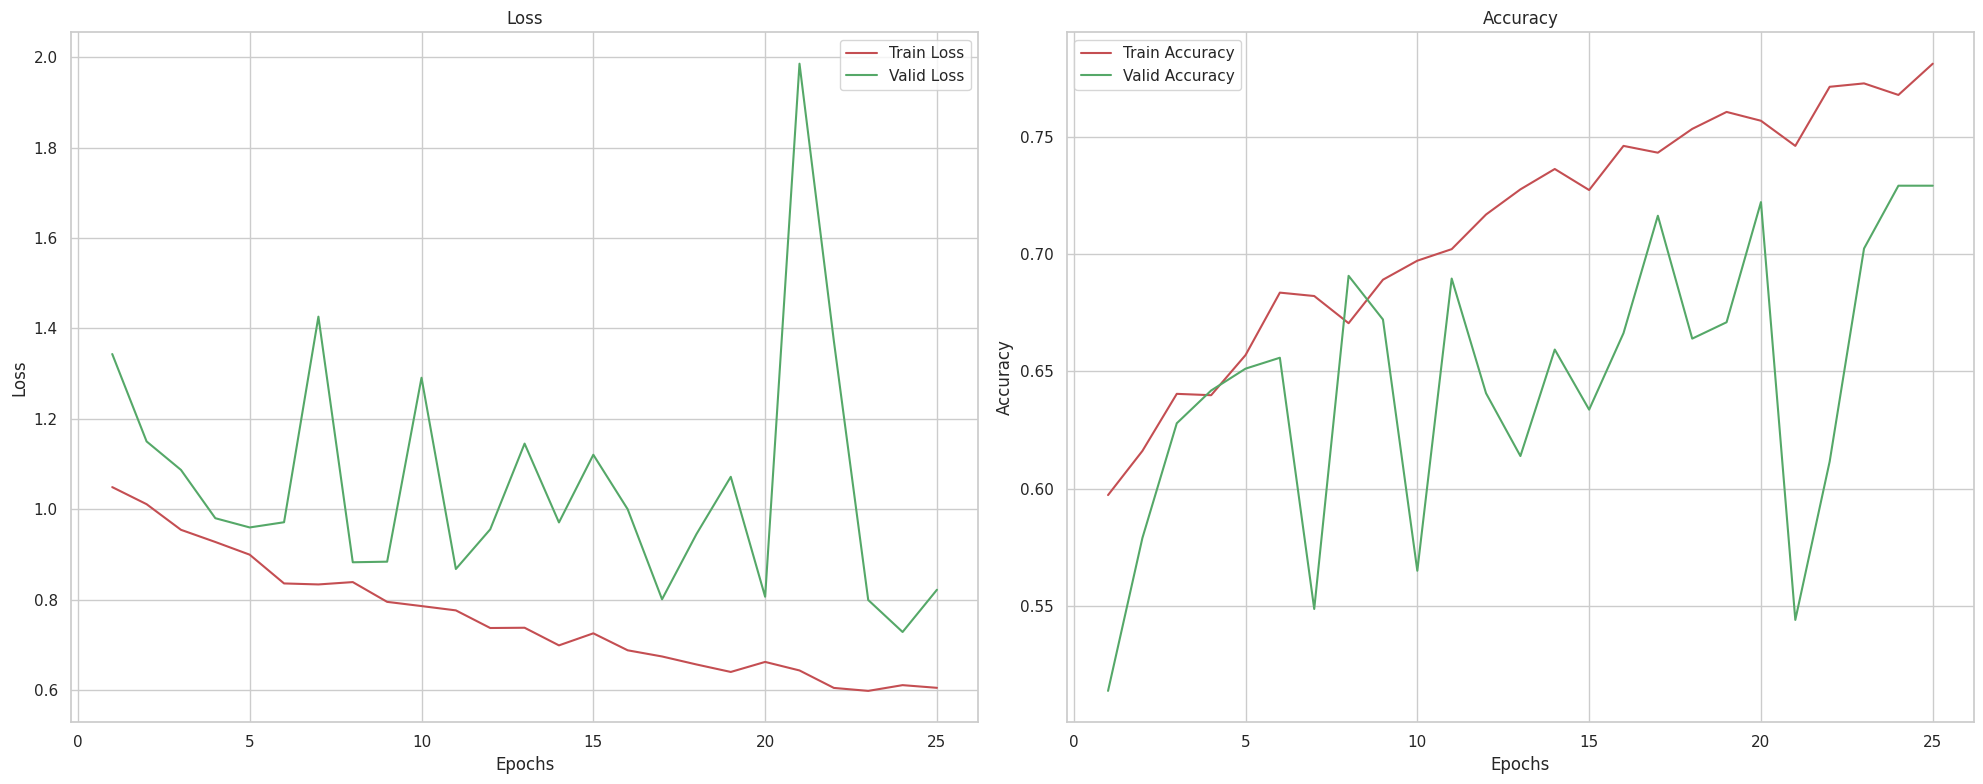

In [42]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Testing of the model 

In [54]:
import cv2
target_img = cv2.imread('/content/tulip_test.jpg')

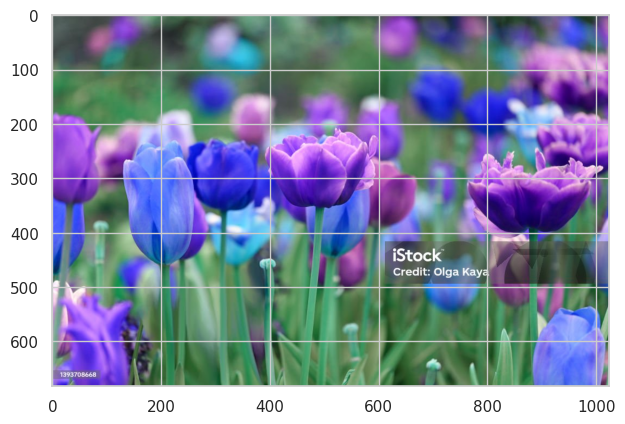

In [55]:
plt.imshow(target_img)

In [56]:
target_img.shape

(682, 1024, 3)

In [57]:
target_img = cv2.resize(target_img,(150,150))

In [58]:
target_img=target_img.reshape((1,150,150,3))

In [60]:
prob_pred=model.predict(target_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [71]:
pred=np.argmax(prob_pred)

In [72]:
pred


4

# Save the model in H5 format

In [63]:
model.save('model.h5')

In [65]:
model.predict(target_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


array([[0., 0., 0., 0., 1.]], dtype=float32)